- Use GPyTorch
- Eclipsing binary + Pulsation + noise
- Remove the eclipsing binary signal (using periodic window) and model the rest of the signal
- From the simulations

In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import clip_windows
import experiment_util
from plot_helpers import *
plotter = PlotUtilSPLeaf()

Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
#df = pd.read_csv("data/sim_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df = pd.read_csv("data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

In [5]:
plotter.plot_data(X, Y)

array([0.        , 0.5673045 , 0.56716849, 0.56744051, 0.56703248])

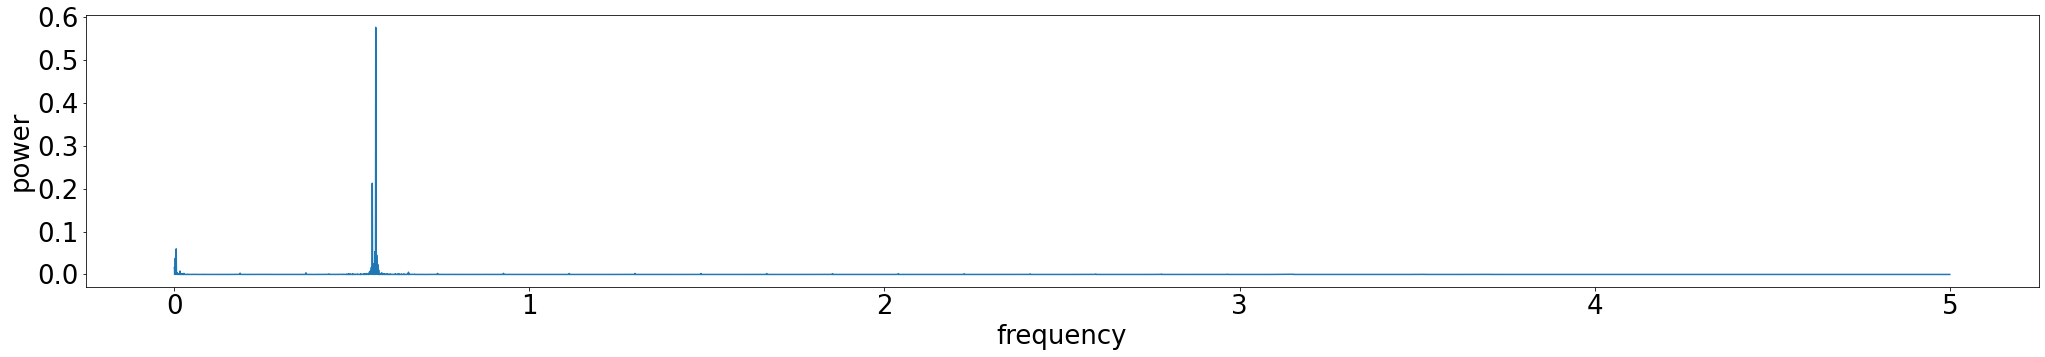

In [6]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)
frequencies[np.argsort(power)[::-1][:5]]

In [7]:
# 11300 is the complete first envelope
N_samples=11300

In [8]:
X_part=X[:N_samples]
Y_part=Y[:N_samples]

In [9]:
# normalize the data
_, _, Y_part = experiment_util.normalize_mean(Y_part)

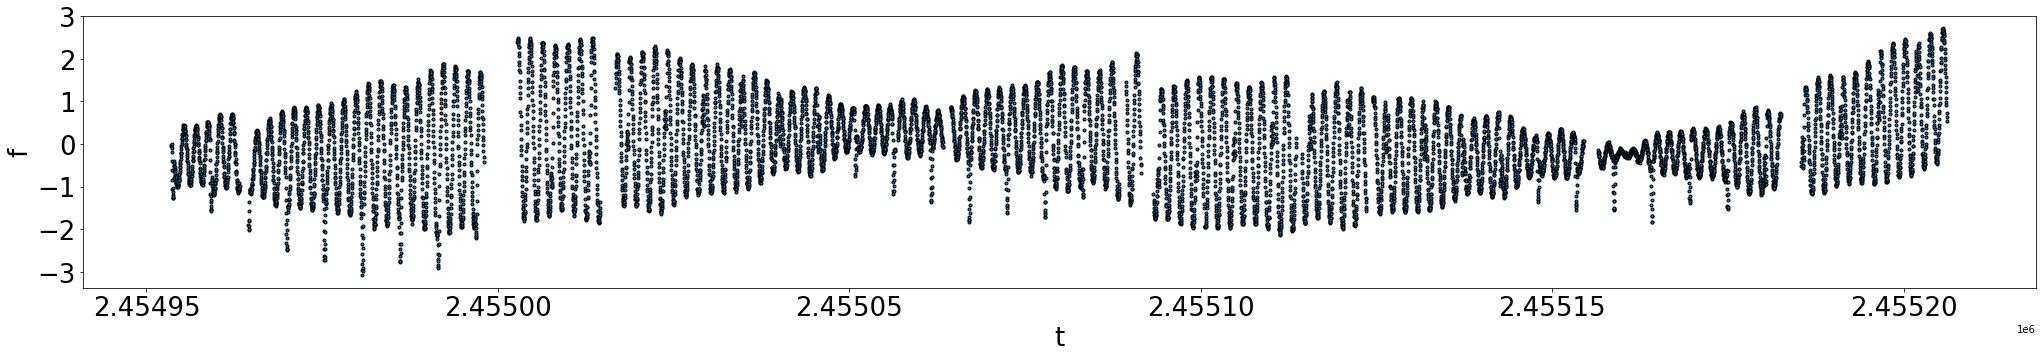

In [10]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [11]:
sample_period = X[1] - X[0]
first_prim_eclipse_date = X_part[0] + (+4) * sample_period
first_sec_eclipse_date = X_part[0] + (+265) * sample_period
eclipse_period=10.790492 # todo: uncertainty

window_size = 25  # todo: window size in duration
eclipse_duration = window_size * sample_period
X_part_window, Y_part_window = clip_windows.clip_periodic_windows(X_part, Y_part, eclipse_duration,
                                                     eclipse_period, 
                                                     first_prim_eclipse_date, first_sec_eclipse_date
                                                    )

In [12]:
# We have all timestamps with observations in X_part
# X_part_window is X_part minus the masked out eclipses
# If we want to plot the mask, subtract X_part_window from X_part and assume
# observations of amplitude 1 at those timestamps
a=X_part
b=X_part_window
X_mask=a
Y_mask=np.zeros(shape=Y_part.shape)
X_mask_idcs=np.searchsorted(a, np.setdiff1d(a, b))
Y_mask[X_mask_idcs]=1

In [13]:
# Now store the timestamps of this gaps for our fitting procedure
X_gaps = X_part[Y_mask==1]

# And remove the observations at the gaps from X and Y
X_without_gaps = X_part[Y_mask==0]
Y_without_gaps = Y_part[Y_mask==0]
plotter.plot_data(X_part[:1000], Y_part[:1000], X_part[:1000], Y_mask[:1000])
plotter.plot_data(X_part[:1000], Y_part[:1000], X_without_gaps[:1000], Y_without_gaps[:1000])
#plotter.plot_data(X_part, Y_part, X_part, Y_mask)
#plotter.plot_data(X_part, Y_part, X_without_gaps, Y_without_gaps)

array([0.        , 0.5669546 , 0.56774643, 0.56616276, 0.56853827,
       0.56537093, 0.56933011, 0.55745257, 0.5582444 , 0.55666073])

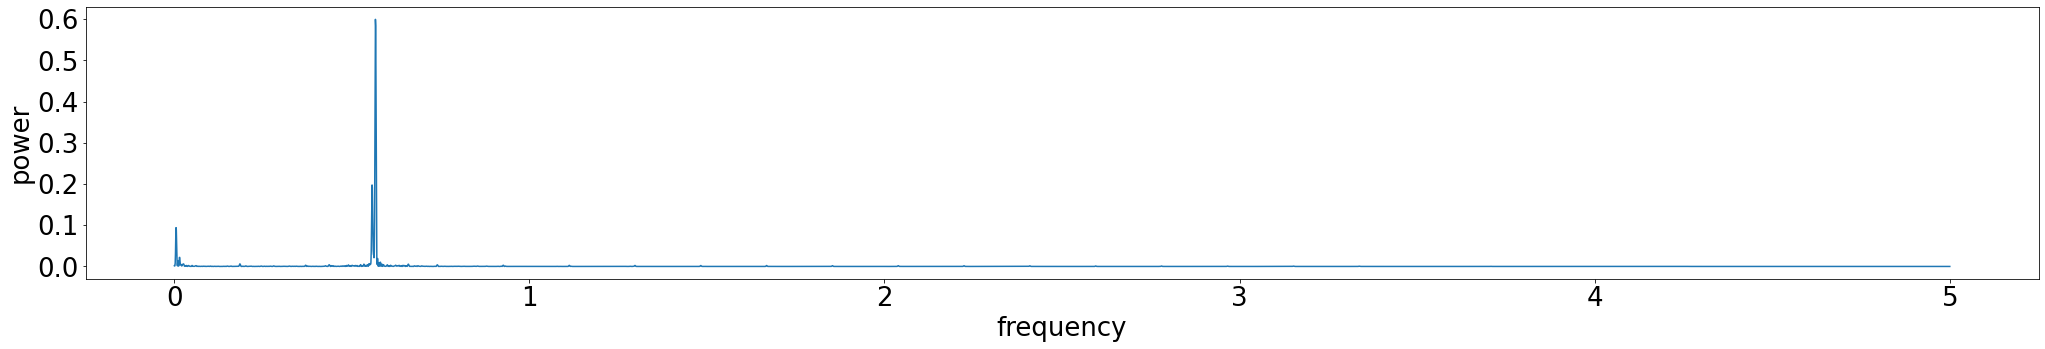

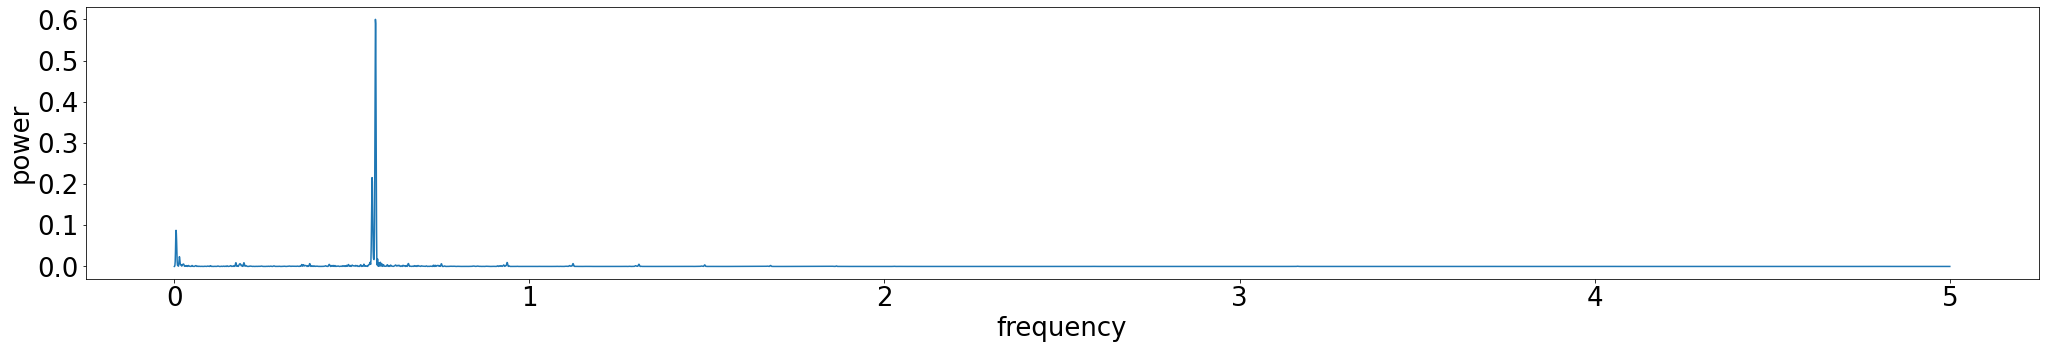

In [14]:
# Plot the periodogram before and after taking out the E.B.
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part, Y_part, 0.0, 5)
frequencies, power = plotter.plot_lomb_scargle_periodogram(X_part_window, Y_part_window, 0.0, 5)
frequencies[np.argsort(power)[::-1][:10]]

In [15]:
main_period = 1/frequencies[np.argsort(power)[::-1][1]]
1/main_period, main_period

(0.5669545980158144, 1.7638096657117268)

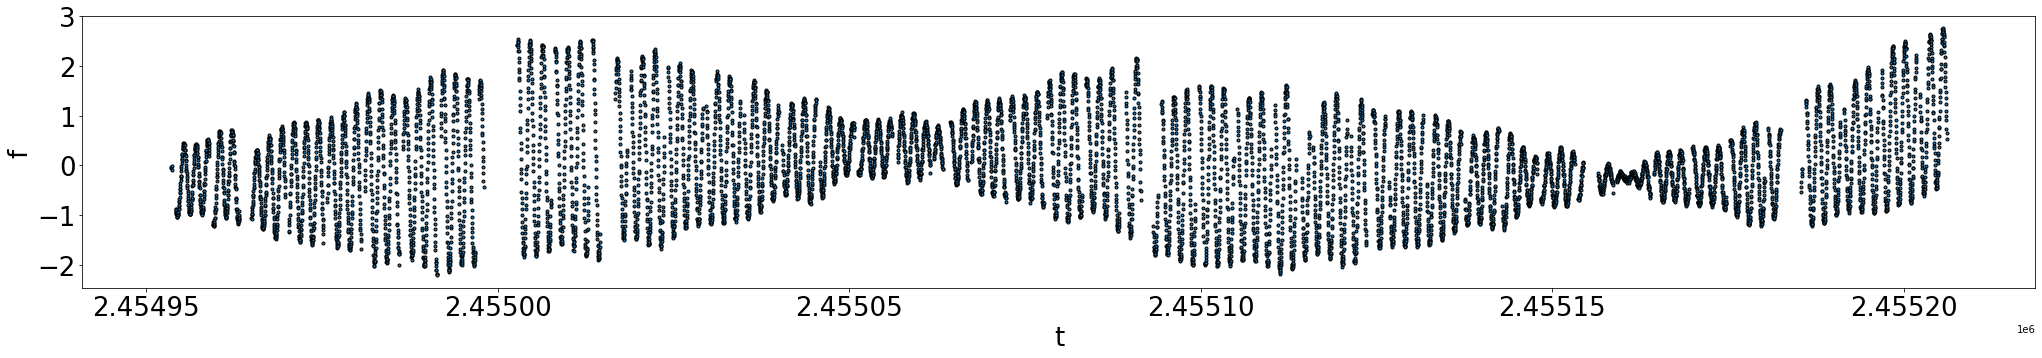

In [16]:
# !! It's important that we normalize *after* removing the E.B. signal, as that E.B. signal 
# has a major impact on the mean?
# In other words, if we normalize first, then remove the E.B., the remaining signal will be 
# somewhere centered around +0.2
# We can not fit any kernel (RBF, Matern...) to a non-normalized signal!!
mean, std, Y_part_window = experiment_util.normalize_mean(Y_part_window)
_, _, Y_part = experiment_util.normalize_mean(Y_part)
plotter.plot_data(X_part_window, Y_part_window)

In [17]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [18]:
# Initialize the S+LEAF model

# Two stochastically-driven harmonic oscillator
# One Uncorrelated measurement errors (yerr)
# Calibration errors (correlated noise)
calib_id = (X_without_gaps//1).astype(int) # One calibration per day
caliberr = np.random.uniform(0.5, 1.5, calib_id[-1]+1)
yerr_calib = caliberr[calib_id]

#cov_matrix = cov.Cov(X_without_gaps,
#   err = term.Error(1),
#   sho = term.SHOKernel(sig=-0.04314, P0=main_period, Q=8019.36505))

# We should try this one instead.
cov_matrix = cov.Cov(X_without_gaps,
   err = term.Error(1),
   sho1 = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=8000.36505),
   sho2 = term.SHOKernel(sig=-0.0000000004314, P0=1/0.5575, Q=200000.36505))

In [19]:
# List of parameters to fit: all (for now)
params_to_fit = cov_matrix.param

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part_window, cov_matrix, params_to_fit))

In [20]:
xbest

array([-1.74467631e+01,  1.78406999e+00,  8.00036503e+03, -1.12843294e+00,
        1.78407483e+00,  2.00000365e+05])

In [21]:
# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest, params_to_fit)
Y_part_pred, var_pred = cov_matrix.conditional(Y_part_window, X_part, calc_cov='diag')

In [22]:
experiment_util.calculate_error(Y_part, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9616410922306252, rmse=0.275057964143709)

In [23]:
plotter.plot_series(X_part_window, Y_part_window, X_part, Y_part_pred)

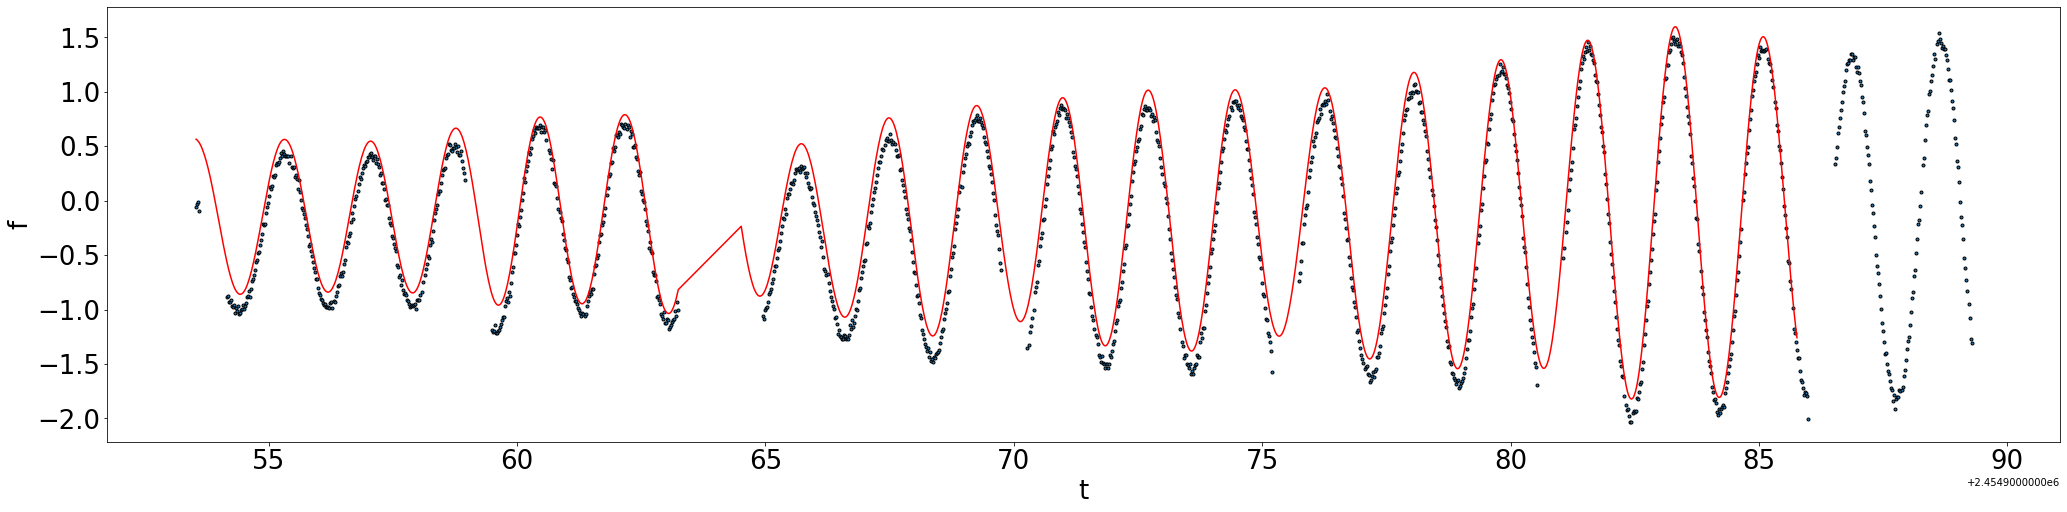

In [24]:
plotter.plot_series(X_part_window[:1500], Y_part_window[:1500], X_part[:1500], Y_part_pred[:1500])

# Correlation between the pulsation+noise data and the full data with E.B. removed

In [25]:
#df = pd.read_csv("./data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df = pd.read_csv("./data/sim_noisy_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
X_orig_pulse, Y_orig_pulse = df['Time'].tolist(), df['Lc'].tolist()
X_orig_pulse, Y_orig_pulse = np.array(X_orig_pulse), np.array(Y_orig_pulse)
X_orig_pulse = X_orig_pulse[:N_samples]
Y_orig_pulse = Y_orig_pulse[:N_samples]

In [26]:
# normalize the data, using the same formula as for the full signal!
_, _, Y_orig_pulse = experiment_util.normalize_mean(Y_orig_pulse)

In [27]:
experiment_util.calculate_error(Y_orig_pulse, Y_part_pred)

TimeSeriesSimilarity(correlation=0.9808128269364761, rmse=0.1977598400398916)

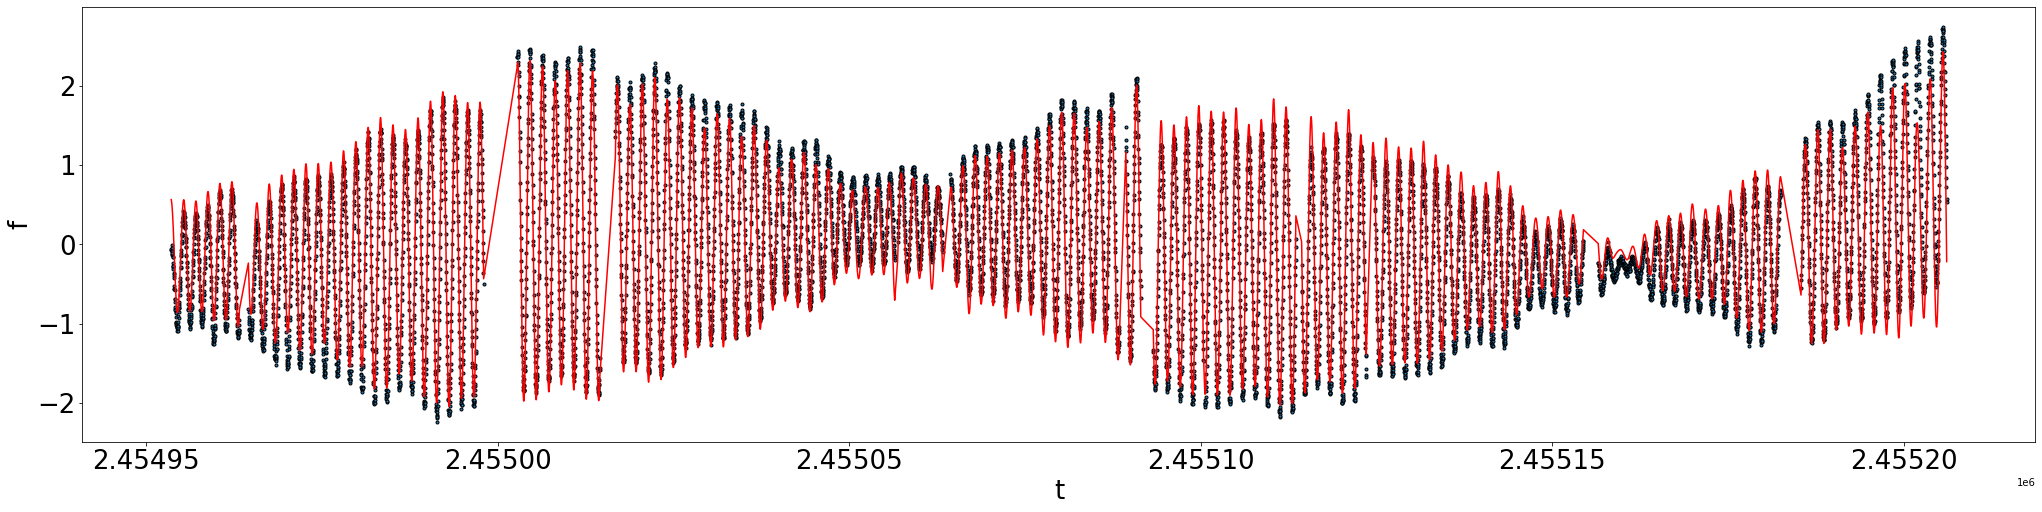

In [28]:
# Now plot our processed lightcurve over the artificial pulse only lightcurve. They should be the same!
plotter.plot_series(X_orig_pulse, Y_orig_pulse, X_part, Y_part_pred)